In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Class 19: Optimal Monetary Policy in the New-Keynesian Model

In this notebook, we will derive and compute the optimal monetary policy response to exogenous shocks in the new-Keynesian model.

## The New-Keynesian Model

Consider the New-Keynesian model without a specification for monetary policy:

\begin{align}
y_t & = E_t y_{t+1}  - \left( r_{t} - \bar{r}\right) + g_t\\
i_{t} & = r_{t} + E_t \pi_{t+1}\\
\pi_t & = \beta E_t\pi_{t+1}  + \kappa y_t+ u_t,
\end{align}

where $\bar{y}$ and $\pi^T$ have been set to zero. We can interpret $y$ as the output gap (log difference of output from steady state). The system above has three equations, but four endogenous variables: $y_t$, $\pi_t$, $i_t$, and $r_t$ ($u_t$ and $g_t$ are exogenous to the system). Previously, we closed the model by assuming a *rule* for monetary that specified the nominal interest rate as a linear function of inflation and output. Here we will derive optimal monetary policy.

## The Optimization Problem 

Suppose that the central bank has preferences over inflation and output in period $t$ is represented by the *loss function*:

\begin{align}
L\left(\pi_t, y_t\right) & = \frac{1}{2}\bigg[\pi_t^2 + \lambda y_t^2\bigg].
\end{align}

The loss function reflects the degree of disutility that the central bank incurs when inflation and the output gap are different from zero. $\lambda$ denotes the weight that the central bank places on output fluctuations. If $\lambda =0$, then central bank cares only about inflation stabilization. A value for $\lambda>0$ means that the central bank wants to stabilize output and inflation. In the US, the Fed is required by law to promote inflation *and* employment stability and so $\lambda>0$ would make sense for a model of the Fed's decisionmaking.

The unconstrained minimum of $L$ is obtained at $\pi_t= 0$ and $y_t = 0$. But often this is not feasible given the constraints of the model. To see why, note that the new-Keynesian Phillips curve imposes a constraint on the feasible combinations of output and inflation. Therefore, the central bank's optimization problem is to solve:

\begin{align}
\min_{\pi, y} \frac{1}{2}\bigg[\pi^2 + \lambda y^2\bigg]
\end{align}

subject to:

\begin{align}
\pi & = \beta \pi' + \kappa y + u
\end{align}

where time subscripts have been dropped. $\pi'$ means expected inflation next period.

The problem can be recast as an unconstrained optimization problem by substituting the Phillips curve into the loss function to eliminate inflation:

\begin{align}
\min_{y} \frac{1}{2}\bigg[\left(\beta \pi' + \kappa y + u\right)^2 + \lambda y^2\bigg]
\end{align}

The first-order condition with respect to $y$ is:

\begin{align}
\kappa \underbrace{\left(\beta \pi' + \kappa y + u\right)}_{\pi} + \lambda y & = 0
\end{align}

or:

\begin{align}
\pi & = -\frac{\lambda}{\kappa}y
\end{align}

Since the central bank solves the same problem in each period, we have the final equation for the system given in the first section:

\begin{align}
\boxed{\pi_t  = -\frac{\lambda}{\kappa}y_t}
\end{align}

This equation expresses the optimal outcome of monetary policy. It should maintain a fixed proportional relationship between output and inflation that depends only on $\lambda$ and $\kappa$. Given this equation, the optimal setting of the nominal interest rate is determined by the IS and Fisher equations.


## Exogenous Shocks and Parameters

As usual, the variables $g_t$ and $u_t$ represent exogenous shocks to aggregate demand and inflation. They follow AR(1) processes:

\begin{align}
g_{t+1} & = \rho_g g_{t} + \epsilon^g_{t+1}\\
u_{t+1} & = \rho_u u_{t} + \epsilon^u_{t+1}.
\end{align}

We will use the following parameterization in the simulations below:

| $$\beta$$ | $$\bar{r}$$    | $$\kappa$$ | $$\rho_g$$ | $$\rho_u$$ | $$\lambda$$ |
|-----------|----------------|------------|------------|------------|-------------|
| 0.995     | $$-\log\beta$$ | 0.25       | 0.5        | 0.5        | 0.1         |

I have assumed a value of 0.1 for $\lambda$, the weight on ouput in the loss function. This value is in the range of estimates for the Fed's loss function.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values (except lambda) in a Pandas Series. PROVIDED
parameters = pd.Series({'beta':0.995,'r_bar':-np.log(0.995),'kappa':0.25,'rho_g':0.5,'rho_u':0.5})

# Add the value for lambda as 'lam' to 'parameters'
parameters['lam'] = 0.1

# Create variable called 'var_names' that stores the variable names in a list with exogenous state variables ordered first, endogenous state variables ordered second, and control variables ordered last. PROVIDED
var_names = ['g','u','y','pi','i','r']

# Create variable called 'shock_names' that stores an exogenous shock name for each exogenous state variable. PROVIDED
shock_names = ['e_g','e_u']

# Define a function that evaluates the equilibrium conditions of the model solved for zero. PROVIDED
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters. PROVIDED
    p = parameters
    
    # Current variables. PROVIDED
    cur = variables_current
    
    # Forward variables. PROVIDED
    fwd = variables_forward

    # IS equation. PROVIDED
    is_equation = fwd.y - (cur.r -p.r_bar) + cur.g - cur.y
    
    # Fisher_equation. PROVIDED
    fisher_equation = cur.r + fwd.pi - cur.i
    
    # Monetary policy. Variable name: 'monetary_policy'
    monetary_policy = p.lam*cur.y  + p.kappa*cur.pi
    
    # Phillips curve. PROVIDED
    phillips_curve = p.beta*fwd.pi + p.kappa*cur.y + cur.u - cur.pi
    
    # Demand process. PROVIDED
    demand_process = p.rho_g*cur.g - fwd.g
    
    # Inflation process. PROVIDED
    inflation_process = p.rho_u*cur.u - fwd.u
    
    # Stack equilibrium conditions into a numpy array. PROVIDED
    return np.array([is_equation,fisher_equation,monetary_policy,phillips_curve,demand_process,inflation_process])


# Initialize the model into a variable named 'nk_model'. PROVIDED
nk_model = ls.model(equations = equilibrium_equations,n_states=2,n_exo_states=2,var_names=var_names,shock_names=shock_names,parameters = parameters)


# Compute the steady state numerically using .compute_ss() method of nk_model. PROVIDED
nk_model.compute_ss([0,0,0,0.01,0.01,0.01])

# Find the log-linear approximation around the non-stochastic steady state and solve using .approximate_and_solve() method of nk_model
# set argumement 'log_linear' to False because the model is already log-linear.
nk_model.approximate_and_solve(log_linear = False)

## Optimal Responses to Shocks

Compute a 21 period impulse responses of the model's variables to a 0.01 unit shock to the exogenous component of  demand ($g_t$) and a 0.01/4 unit shock to the exogenous component of inflation ($u_t$) in period 5.

In [3]:
# Compute the desired impulse responses
nk_model.impulse(shocks=[0.01,0.01/4],T=21,t0=5)

### Demand Shocks

Plot the impulse responses of output and inflation to the demand shock. Multiply output by 100 and multiply inflation by 400 (to annualize the values).

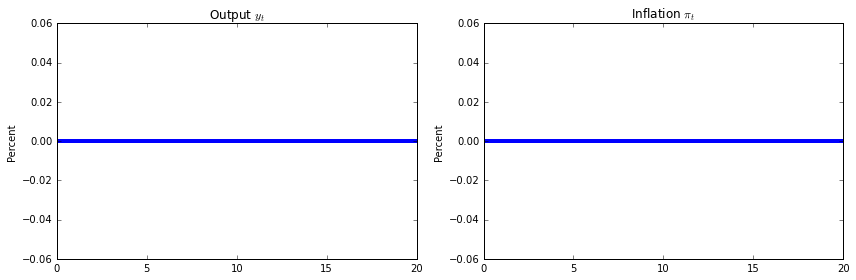

In [4]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create left subplot. PROVIDED
ax1 = fig.add_subplot(1,2,1)
# Create right subplot. PROVIDED
ax2 = fig.add_subplot(1,2,2)

# Left subplot title. PROVIDED
ax1.set_title('Output $y_t$')
# Right subplot title. PROVIDED
ax2.set_title('Inflation $\pi_t$')

# Left subplot y-axis label. PROVIDED
ax1.set_ylabel('Percent')
# Right subplot y-axis label. PROVIDED
ax2.set_ylabel('Percent')

# Plot output on left axis
ax1.plot(nk_model.irs['e_g']['y']*100,lw=4)

# Plot inflation on right axis
ax2.plot(nk_model.irs['e_g']['pi']*400,lw=4)

# Add left subplot grid. PROVIDED
ax1.grid()

# Add right subplot grid. PROVIDED
ax1.grid()

# Manage whitespace. PROVIDED
fig.tight_layout()

Apparently optimal policy entails perfectly offsetting demand shocks so that output and inflation are perfectly stabilized. This is because there is no tradeoff in stabilizing output versus inflation in the face of a demand shock.

### Inflation Shocks

Plot the impulse responses of output and inflation to the inflation shock. Multiply output by 100 and multiply inflation by 400.

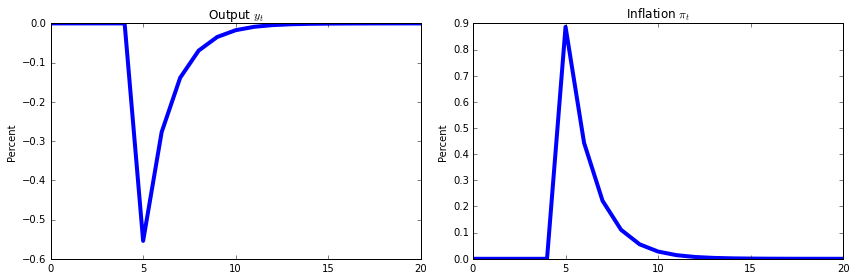

In [5]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,4))

# Create left subplot. PROVIDED
ax1 = fig.add_subplot(1,2,1)
# Create right subplot. PROVIDED
ax2 = fig.add_subplot(1,2,2)

# Left subplot title. PROVIDED
ax1.set_title('Output $y_t$')
# Right subplot title. PROVIDED
ax2.set_title('Inflation $\pi_t$')

# Left subplot y-axis label. PROVIDED
ax1.set_ylabel('Percent')
# Right subplot y-axis label. PROVIDED
ax2.set_ylabel('Percent')

# Plot output on left axis
ax1.plot(nk_model.irs['e_u']['y']*100,lw=4)

# Plot inflation on right axis
ax2.plot(nk_model.irs['e_u']['pi']*400,lw=4)

# Add left subplot grid. PROVIDED
ax1.grid()

# Add right subplot grid. PROVIDED
ax1.grid()

# Manage whitespace. PROVIDED
fig.tight_layout()

The Phillips curve implies that there *is* a tradeoff in stabilizing output versus inflation in the face of an inflation shock. The optimal policy is to allow inflation to rise and to allow output to fall so that the full force of the shock does not fall on inflation.

## Stochastic Simulation with Optimal Monetary Policy


Now we simulate how would output and inflation evolve if monetary policy were set optimally. Specifically, construct a 201 period stochastic simulation with the seed for the random number generator set to 126. Note that the shock covariance matrix for the model is:

\begin{align}
\text{Covariance matrix} & = \left[\begin{array}{cc}\sigma_g^2 & 0\\ 0 & \sigma_u^2\end{array}\right]
\end{align}

Use the following values for $\sigma_g$ and $\sigma_u$ in the simulation:

| $$\sigma_g$$ | $$\sigma_u$$ |
|--------------|--------------|
| 0.015        | 0.003        |

In [6]:
# Define variable 'sig_g' equal to the the standard deviation of sigma_g
sig_g = 0.015

# Define variable 'sig_u' equal to the the standard deviation of sigma_u
sig_u = 0.003

# Compute simulation
nk_model.stoch_sim(cov_mat = [[sig_g**2,0],[0,sig_u**2]],T=201,seed=126)

Plot the simulated values of output and inflation.

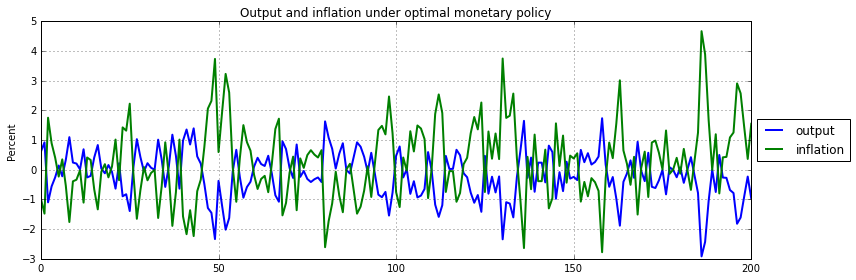

In [7]:
# Create figure. PROVIDED
fig = plt.figure(figsize=(12,4))
# Create subplot. PROVIDED
ax = fig.add_subplot(1,1,1)
# Add plot title. PROVIDED
ax.set_title('Output and inflation under optimal monetary policy')
# y-axis label. PROVIDED
ax.set_ylabel('Percent')

# Plot output
(nk_model.simulated['y']*100).plot(lw=2,label='output')

# Plot inflation
(nk_model.simulated['pi']*400).plot(lw=2,label='inflation')

# Construct legend. PROVIDED
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add grids. PROVIDED
ax.grid()

# Manage whitespace. PROVIDED
fig.tight_layout()

Compute the correlations of output and inflation under optimal monetary policy.

In [8]:
# Correlations of output and inflation
nk_model.simulated[['y','pi']].corr()

,y,pi
y,1.0,-1.0
pi,-1.0,1.0


By requiring that output be proportional to inflation, the optimal monetary policy implies perfect negative correlation between output and inflation. All demand shocks are neutralized.